# Load dataset & preprocessing

In [1]:
import pandas as pd
import numpy as np

root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
exp_dir = "datasets/infuluenza/LSTM/"

df = pd.read_csv(data_path)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_tokyo = df[df['regnames'].isin(["Tokyo"])]

df_tokyo.head()

,Alltime,Time,region,regnames,Longitude,Latitude,Altitude,Year,Month,Week,Flucases,Holiday,Tempave,Tempmin,Tempmax,Rh
12480,12481,1,13,Tokyo,35.689185,139.691648,34.9,2000,1,1,818,2,9.528571,6.371429,13.385714,50.571429
12481,12482,2,13,Tokyo,35.689185,139.691648,34.9,2000,1,2,1167,3,8.642857,5.457143,12.000000,61.142857
12482,12483,3,13,Tokyo,35.689185,139.691648,34.9,2000,1,3,2562,2,6.828571,4.171429,9.500000,56.000000
12483,12484,4,13,Tokyo,35.689185,139.691648,34.9,2000,1,4,3781,2,5.342857,1.542857,9.400000,42.000000
12484,12485,5,13,Tokyo,35.689185,139.691648,34.9,2000,1,5,3903,2,7.214286,3.171429,11.585714,38.714286


In [3]:
train_n = int(len(df_tokyo["Flucases"])*0.75)
test_n = int(len(df_tokyo["Flucases"])*0.25)
train_n, test_n

(780, 260)

In [4]:
train_steps = np.arange(train_n)
test_steps = np.arange(train_n,train_n + test_n)

In [5]:
columns = ["Flucases","Tempave", "Rh", "Holiday"]

all_data = df_tokyo[columns]

In [6]:
train_df = all_data[columns][0:train_n]
test_df = all_data[columns][train_n:train_n+test_n]

In [7]:
train_df.head()

,Flucases,Tempave,Rh,Holiday
12480,818,9.528571,50.571429,2
12481,1167,8.642857,61.142857,3
12482,2562,6.828571,56.000000,2
12483,3781,5.342857,42.000000,2
12484,3903,7.214286,38.714286,2


In [8]:
test_df.head()

,Flucases,Tempave,Rh,Holiday
13260,3809,5.357143,47.142857,3
13261,9892,6.285714,38.285714,2
13262,8198,5.628571,53.857143,3
13263,9625,6.771429,63.714286,2
13264,7844,4.228571,49.000000,2


trainとtestのdfを作る

In [9]:
train_ts_df = train_df["Flucases"]
train_ys_df = train_df[["Tempave", "Rh"]]
train_xs_df = train_df["Holiday"]

test_ts_df = test_df["Flucases"]
test_ys_df = test_df[["Tempave", "Rh"]]
test_xs_df = test_df["Holiday"]

In [10]:
seq_length = 26

# Dataset and DataLoader

In [11]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
from torch.nn import Sequential, Linear, Tanh, Sigmoid, LeakyReLU, ReLU
import torch.nn.functional as F
import torch.optim as optim

import numpy as np #数値計算用ライブラリ
import matplotlib.pyplot as plt #描画用ライブラリ

In [12]:
root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
data_dir = "datasets/infuluenza/vecLSTMx/"
exp_dir = "datasets/infuluenza/LSTM/"

In [13]:
import joblib

# スケーラーの読み込み
std_scaler = joblib.load(data_dir + 'std_scaler.joblib')

In [14]:
train_Xs = np.load(data_dir + "train_Xs_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_ys_" + str(seq_length) + "w.npy")
val_Xs = np.load(data_dir + "val_Xs_" + str(seq_length) + "w.npy")
val_ys = np.load(data_dir + "val_ys_" + str(seq_length) + "w.npy")

In [15]:
trn_xs_tensor = torch.Tensor(train_Xs[:,:,0:1])
trn_ys_tensor = torch.Tensor(train_ys[:,:,0:1])

val_xs_tensor = torch.Tensor(val_Xs[:,:,0:1])
val_ys_tensor = torch.Tensor(val_ys[:,:,0:1])

In [16]:
trn_xs_tensor.shape, trn_ys_tensor.shape, val_xs_tensor.shape, val_ys_tensor.shape

(torch.Size([603, 26, 1]),
 torch.Size([603, 1, 1]),
 torch.Size([151, 26, 1]),
 torch.Size([151, 1, 1]))

In [17]:
from torch.utils.data import TensorDataset, DataLoader

trn_dataset = TensorDataset(trn_xs_tensor, trn_ys_tensor)
trn_loader = DataLoader(dataset=trn_dataset,batch_size=50,shuffle=True)

val_dataset = TensorDataset(val_xs_tensor, val_ys_tensor)
val_loader = DataLoader(dataset=val_dataset,batch_size=50,shuffle=False)

In [18]:
for id, batch_data in enumerate(trn_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
1 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
2 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
3 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
4 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
5 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
6 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
7 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
8 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
9 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
10 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
11 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
12 torch.Size([3, 26, 1]) torch.Size([3, 1, 1])


In [19]:
for id, batch_data in enumerate(val_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
1 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
2 torch.Size([50, 26, 1]) torch.Size([50, 1, 1])
3 torch.Size([1, 26, 1]) torch.Size([1, 1, 1])


# LSTM model

In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size=32, output_size=1, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2)
        
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden)
        outs = last_outs[:, -1, :] #(batch_size, hidden)
 
        h = self.relu(self.fc1(outs))
        y = self.relu(self.fc2(h))

        return y

In [23]:
model = LSTM(input_size = 1, hidden_size = 16, output_size = 1, num_layers = 1)

## Prediction

In [22]:
batch_0x = list(trn_loader)[0][0]

In [23]:
batch_0x.shape

torch.Size([50, 26, 1])

In [24]:
preds = model(batch_0x)

In [25]:
preds.shape

torch.Size([50, 1])

## Train

In [26]:
model.cuda()

LSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(1, 16, dropout=0.2)
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [27]:
criterion = nn.MSELoss(reduction='mean').cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [28]:
def val_model(epoch):
    
    model.eval()
    
    sum_errors = 0
    
    for batch_data in val_loader:
       
        with torch.no_grad():
            
            if torch.cuda.is_available():
                inputs, trues = batch_data
                inputs, trues = inputs.cuda(), trues.cuda()

            preds = model(inputs)
            true_y = trues.reshape(preds.shape)
            loss = criterion(preds, true_y)
            
            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()
            
    return sum_errors / len(val_loader)

In [29]:
train_loss_hist = []
val_loss_hist = []
best_loss = 1e10
n_epochs = 500

for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0
    
    for batch_data in trn_loader:
        
        inputs, trues = batch_data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        optimizer.zero_grad()
        
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        loss = criterion(preds, true_y)
        
        loss.backward() #偏微分を計算
        
        train_loss += loss.item()

        #パラメータを更新する
        optimizer.step()
    
    val_loss = val_model(epoch)
    train_loss_hist.append(train_loss / len(trn_loader))
    val_loss_hist.append(val_loss)
    
    print("epoch: ", epoch, "Train loss: ", train_loss / len(trn_loader), "Val loss: ", val_loss)
    
    if val_loss < best_loss:
        save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"
        torch.save(model, save_model_path)
        best_loss = val_loss

epoch:  0 Train loss:  0.8901860656646582 Val loss:  0.6402034034545068
epoch:  1 Train loss:  0.7364823709313686 Val loss:  0.6035933680832386
epoch:  2 Train loss:  0.7048687149698918 Val loss:  0.5802657189778984
epoch:  3 Train loss:  0.6742836990608618 Val loss:  0.5512676308862865
epoch:  4 Train loss:  0.6391058114285653 Val loss:  0.510711703915149
epoch:  5 Train loss:  0.6523253482121688 Val loss:  0.4567962335422635
epoch:  6 Train loss:  0.5503758157675083 Val loss:  0.378496740013361
epoch:  7 Train loss:  0.41792104794428897 Val loss:  0.2848067535087466
epoch:  8 Train loss:  0.30665494300998175 Val loss:  0.18912921752780676
epoch:  9 Train loss:  0.19870348919469577 Val loss:  0.12432978441938758
epoch:  10 Train loss:  0.12383568057647118 Val loss:  0.09910548059269786
epoch:  11 Train loss:  0.1086223371900045 Val loss:  0.09802448656409979
epoch:  12 Train loss:  0.1058658636891498 Val loss:  0.11473892303183675
epoch:  13 Train loss:  0.10948837702520765 Val loss: 

epoch:  111 Train loss:  0.09459784888447477 Val loss:  0.08778202583926031
epoch:  112 Train loss:  0.09557619912979695 Val loss:  0.08742557394725736
epoch:  113 Train loss:  0.09535002804029948 Val loss:  0.08906585807199008
epoch:  114 Train loss:  0.0949754137904025 Val loss:  0.08724272292238311
epoch:  115 Train loss:  0.09594172844663262 Val loss:  0.08929014379464206
epoch:  116 Train loss:  0.10335472956872903 Val loss:  0.08838746599394653
epoch:  117 Train loss:  0.0975804933337853 Val loss:  0.08593945962252292
epoch:  118 Train loss:  0.09908249830970398 Val loss:  0.08782657956362527
epoch:  119 Train loss:  0.10572207948336235 Val loss:  0.0896477763508301
epoch:  120 Train loss:  0.09747942615873538 Val loss:  0.08844049471372273
epoch:  121 Train loss:  0.10938408240102805 Val loss:  0.08834620850393549
epoch:  122 Train loss:  0.09682897793111177 Val loss:  0.0916948463418521
epoch:  123 Train loss:  0.09666864790667135 Val loss:  0.0882014338276349
epoch:  124 Train

epoch:  220 Train loss:  0.10166220925748348 Val loss:  0.08321182981308084
epoch:  221 Train loss:  0.09597634896636009 Val loss:  0.08300164620251849
epoch:  222 Train loss:  0.09443364987293115 Val loss:  0.08407080989309179
epoch:  223 Train loss:  0.09482889933189234 Val loss:  0.08595777839218499
epoch:  224 Train loss:  0.11031393950375226 Val loss:  0.08627786860115805
epoch:  225 Train loss:  0.09947369047082387 Val loss:  0.08626871580554507
epoch:  226 Train loss:  0.09653160692407535 Val loss:  0.08699782317853533
epoch:  227 Train loss:  0.09510044285091751 Val loss:  0.08520372194470838
epoch:  228 Train loss:  0.09508750594865817 Val loss:  0.08730412129079923
epoch:  229 Train loss:  0.10685383901000023 Val loss:  0.08511914790142328
epoch:  230 Train loss:  0.09755139395080328 Val loss:  0.08575647749239579
epoch:  231 Train loss:  0.10187949784673177 Val loss:  0.08780469885095954
epoch:  232 Train loss:  0.09647225845107571 Val loss:  0.0883519712369889
epoch:  233 T

epoch:  329 Train loss:  0.10085063148289919 Val loss:  0.0835695412097266
epoch:  330 Train loss:  0.09469850666706546 Val loss:  0.08347718417644501
epoch:  331 Train loss:  0.0973327557484691 Val loss:  0.08301410014973953
epoch:  332 Train loss:  0.10163772048858496 Val loss:  0.08442777482559904
epoch:  333 Train loss:  0.09594714240385936 Val loss:  0.08204316507908516
epoch:  334 Train loss:  0.10439546105380242 Val loss:  0.08377488888800144
epoch:  335 Train loss:  0.09413623138635348 Val loss:  0.08238633511064108
epoch:  336 Train loss:  0.09603669335676666 Val loss:  0.0846528018155368
epoch:  337 Train loss:  0.09644022271431123 Val loss:  0.08372905761098082
epoch:  338 Train loss:  0.09778037251761326 Val loss:  0.08498462695570197
epoch:  339 Train loss:  0.0977005610402557 Val loss:  0.08165577518957434
epoch:  340 Train loss:  0.09577954599920374 Val loss:  0.08149755656631896
epoch:  341 Train loss:  0.11458807166379231 Val loss:  0.08248680568067357
epoch:  342 Trai

epoch:  439 Train loss:  0.1901270721394282 Val loss:  0.08180966015788727
epoch:  440 Train loss:  0.10098612150334073 Val loss:  0.09076257742708549
epoch:  441 Train loss:  0.10058536710074314 Val loss:  0.08863914155517705
epoch:  442 Train loss:  0.10058381637701622 Val loss:  0.0827909288709634
epoch:  443 Train loss:  0.09439440648286389 Val loss:  0.08076871454250067
epoch:  444 Train loss:  0.0949870562106718 Val loss:  0.08214598341146484
epoch:  445 Train loss:  0.09967379759137447 Val loss:  0.08321288562729023
epoch:  446 Train loss:  0.096320229752634 Val loss:  0.08476354973390698
epoch:  447 Train loss:  0.0955717358738184 Val loss:  0.08314033912029117
epoch:  448 Train loss:  0.09768672088662592 Val loss:  0.08249102157424204
epoch:  449 Train loss:  0.09926534057236634 Val loss:  0.0832025277777575
epoch:  450 Train loss:  0.10375613934145524 Val loss:  0.08420912310248241
epoch:  451 Train loss:  0.09722346654878213 Val loss:  0.08539614581968635
epoch:  452 Train l

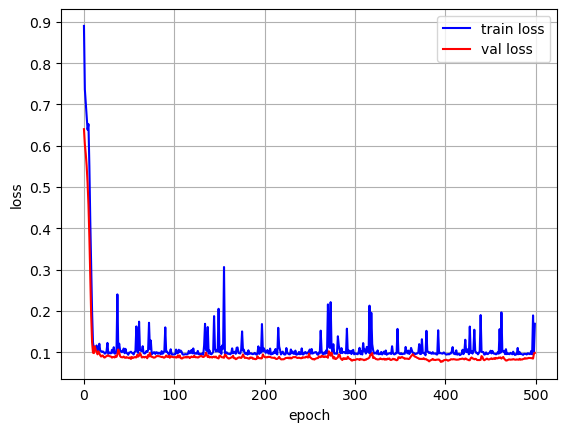

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_hist)), train_loss_hist, c='b', label='train loss')
plt.plot(range(len(val_loss_hist)), val_loss_hist, c='r', label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [31]:
np.argmin(val_loss_hist), np.min(val_loss_hist)

(395, 0.07666731159042683)

In [24]:
save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"

model = torch.load(save_model_path)

### Scatter plot

In [25]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(trn_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [26]:
np.array(trues_list).shape, np.array(preds_list).shape

((603, 1, 1), (603, 1, 1))

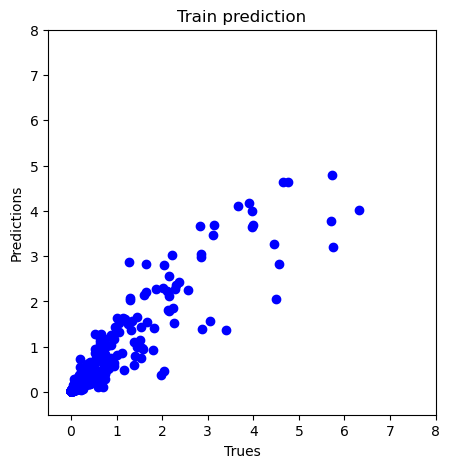

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Train prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

In [28]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(val_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


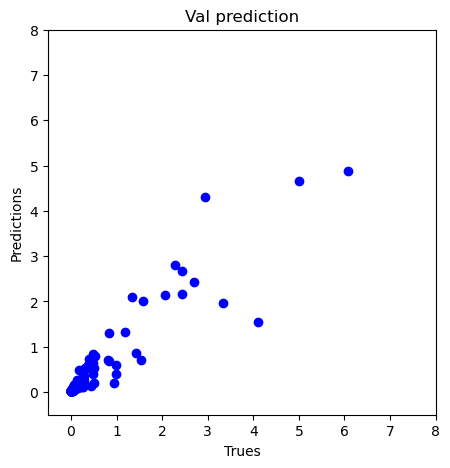

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Val prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

## Test prediction

In [30]:
#test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

train_np = np.load(data_dir + "train_np.npy")
test_np = np.load(data_dir + "test_np.npy")

In [31]:
train_np.shape, test_np.shape

((780, 4), (260, 4))

In [32]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

test_scaled_ts = (np.array(test_np[:,0]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [33]:
test_scaled_ys = std_scaler.transform(test_np[:,1:3])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [34]:
test_scaled_ys.shape, test_scaled_ts.reshape(-1,1).shape, test_np[:,-1].shape

((260, 2), (260, 1), (260,))

In [35]:
test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

In [36]:
test_all_np.shape

(260, 4)

In [37]:
test_np[:,-1].shape, test_scaled_ts.shape, test_scaled_ys.shape, test_np.shape

((260,), (260,), (260, 2), (260, 4))

### 1. Prediction based on results from 40 days ago

In [38]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [39]:
test_Xs, test_ys = make_sequence_data(test_all_np, seq_length)

In [40]:
test_Xs.shape, test_ys.shape

((234, 26, 4), (234, 1, 4))

In [41]:
tst_xs_tensor = torch.Tensor(test_Xs[:,:,0:1])
tst_ys_tensor = torch.Tensor(test_ys[:,:,0:1])

In [42]:
from torch.utils.data import TensorDataset, DataLoader

tst_dataset = TensorDataset(tst_xs_tensor, tst_ys_tensor)

In [43]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(tst_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


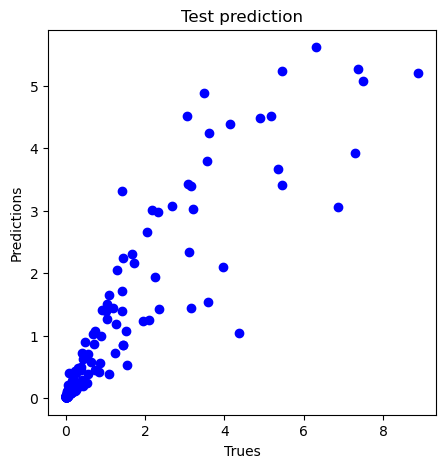

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [45]:
tst_trues, tst_preds = np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0]

In [46]:
tst_preds = (np.array(preds_list)[:,:,0] - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

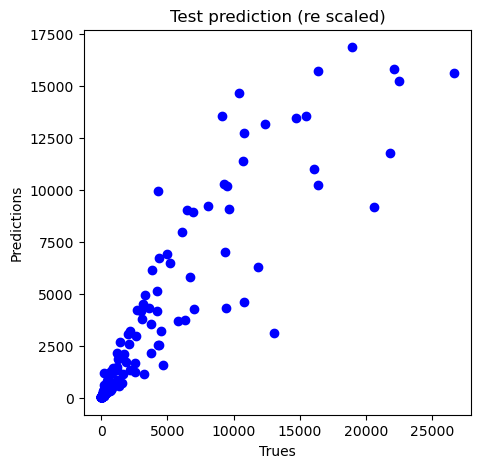

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_np[seq_length:,0], tst_preds, c = "b") # 散布図を描画
plt.title("Test prediction (re scaled)")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [48]:
tst_preds.shape

(234, 1)

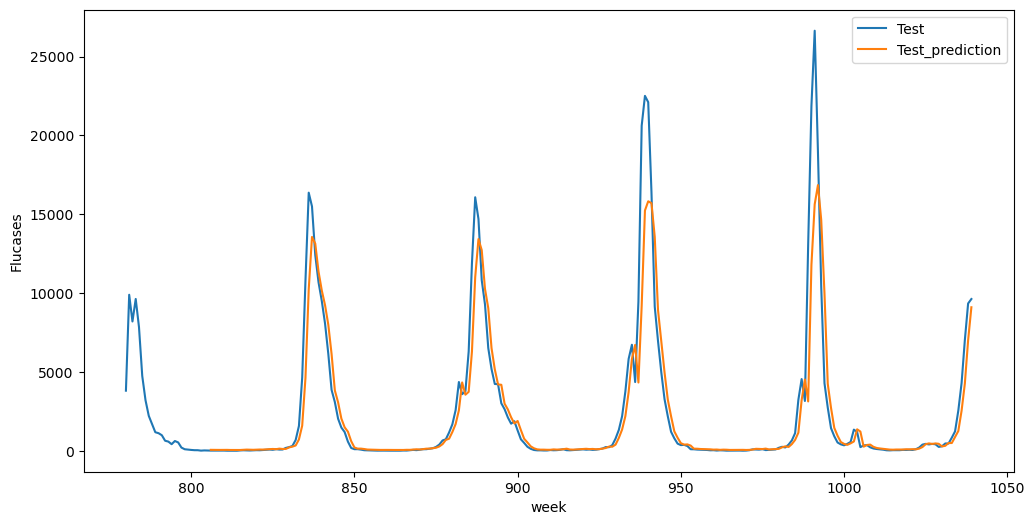

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n],label="Test")
plt.plot(test_steps[seq_length:], tst_preds,label="Test_prediction")

plt.xlabel("week")
plt.ylabel("Flucases")
plt.legend()

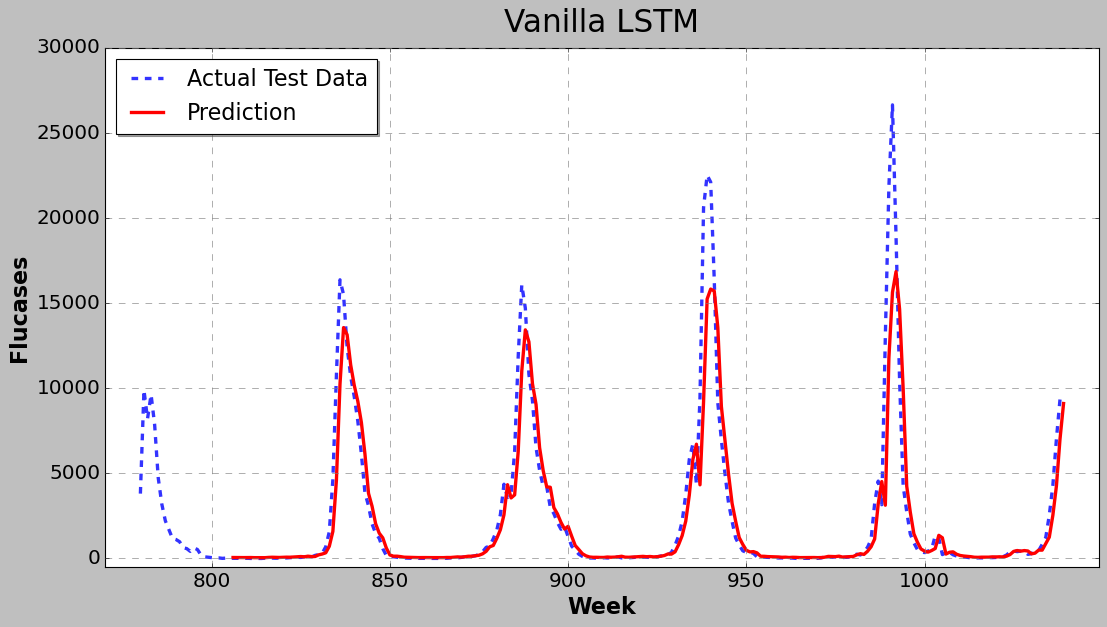

In [56]:
plt.figure(figsize=(14, 8))
plt.style.use('classic')  # スタイリッシュな背景に変更

# 実際のデータと予測データをプロット
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n], label="Actual Test Data", linestyle='--', linewidth=3, color='blue', alpha=0.8)
plt.plot(test_steps[seq_length:], tst_preds, label="Prediction", linestyle='-', linewidth=3, color='red', alpha=1.0)

# 軸ラベルとタイトルを追加
plt.xlabel("Week", fontsize=20, fontweight='bold')
plt.ylabel("Flucases", fontsize=20, fontweight='bold')
plt.title("Vanilla LSTM", fontsize=28, y=1.02)

# グリッドの調整
plt.grid(color='gray', linestyle='--', linewidth=0.75, alpha=0.75)

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# 凡例の調整
plt.legend(fontsize=20, loc='upper left', frameon=True, shadow=True)
plt.ylim(bottom=-500)
plt.xlim(left=min(test_steps) - 10, right = max(test_steps) + 10)

# 仕上げ
plt.tight_layout()
plt.savefig("LSTM.jpg", dpi=200, bbox_inches='tight', format='jpg')
plt.show()

In [59]:
from sklearn.metrics import (
    mean_squared_error,  # MSE
    mean_absolute_error,  # MAE
    r2_score, # R2
)

from scipy.stats import pearsonr

def reg_metric(trues, preds, name):
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    r, p = pearsonr(trues, preds)
    
    print(name)
    print(f'MSE : {mse}.')
    print(f'RMSE : {rmse}.')
    print(f'MAE : {mae}.')
    print(f'R2 : {r2}.')
    print("pearson :", r, p)

In [60]:
reg_metric(test_np[seq_length*2:,0], tst_preds[seq_length:,0], "Flucases")

Flucases
MSE : 4303471.901605003.
RMSE : 2074.481116232443.
MAE : 880.1631401685568.
R2 : 0.8215310821471016.
pearson : 0.9155841724314975 1.910147425793007e-83
